In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook as tqdm

#Cargo datos
df = pd.read_csv('../data/imdb_small.csv')

#Separo datos entrenamiento y datos prueba
trainSize = 6225
testSize = 1000

trainData = df[df.type == 'train'].sample(n=trainSize, random_state=123)
testData = df[df.type == 'test'].sample(n=testSize, random_state=456)

text_train = trainData["review"]
label_train = trainData["label"]

text_test = testData["review"]
label_test = testData["label"]

In [2]:
mindf = 0.01
maxdf = 0.95

vectorizer = CountVectorizer(max_df=maxdf, min_df=mindf, max_features=5000)
vectorizer.fit(text_train)

#Transformo al modelo BoW los datos
X_train, y_train = vectorizer.transform(text_train).toarray(), (label_train == 'pos').values
X_test, y_test = vectorizer.transform(text_test).toarray(), (label_test == 'pos').values

In [3]:
import sentiment

In [6]:
data = []

sizes = [500, 1000, 2000, 3000, 4000, 5000, 6000]
components = 250
k_percentage = 25

pbar = tqdm(total=len(sizes)*components)
for size in sizes:
    X_train_capped = X_train[:size]
    y_train_capped = y_train[:size]
    
    pca = sentiment.PCA(components)
    pca.fit(X_train)

    for component in range(1, components+1):
        
        X_pca_train = pca.transformBeta(X_train_capped, component)
        X_pca_test = pca.transformBeta(X_test, component)
        
        k = max(round(size*k_percentage/100), 1)

        knn = sentiment.KNNClassifier(k)
        knn.fit(X_pca_train, y_train_capped)

        y_pred = knn.predict(X_pca_test)
        acc = accuracy_score(y_test, y_pred)

        data.append((size, component, acc))
        pbar.update(1)
pbar.close()

In [7]:
df = pd.DataFrame(data, columns = ['size', 'component', 'acc'])

In [8]:
df.to_csv('experimentoTamTrainingKnn+PCA')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [13]:
dfAcc = df.pivot('size', 'component', 'acc')

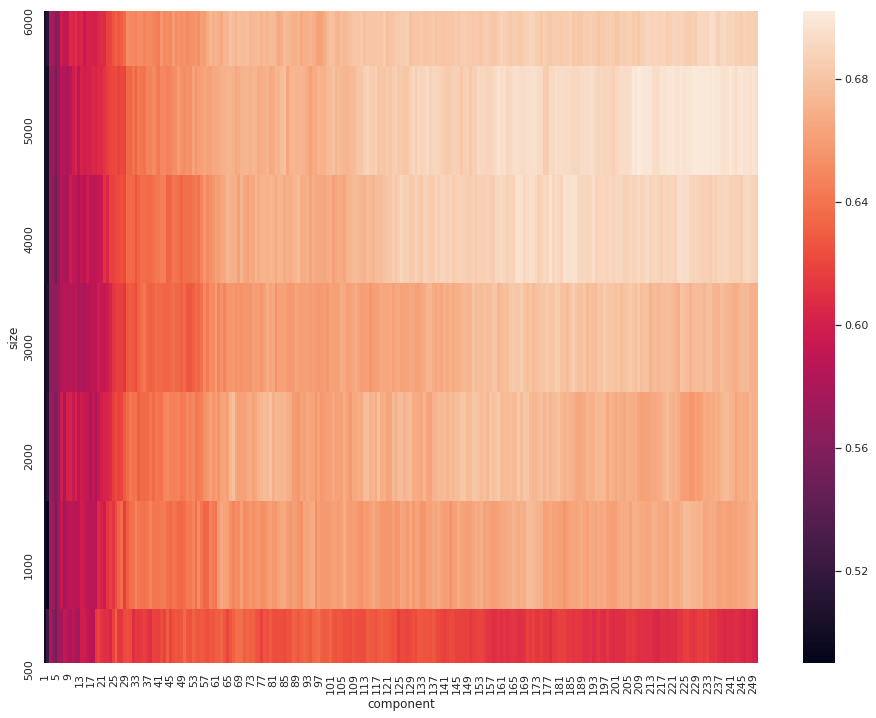

In [22]:
plt.figure(figsize=(16, 12))
ax = sns.heatmap(dfAcc)
#ax.set_ylim(16, 0)
ax.invert_yaxis()

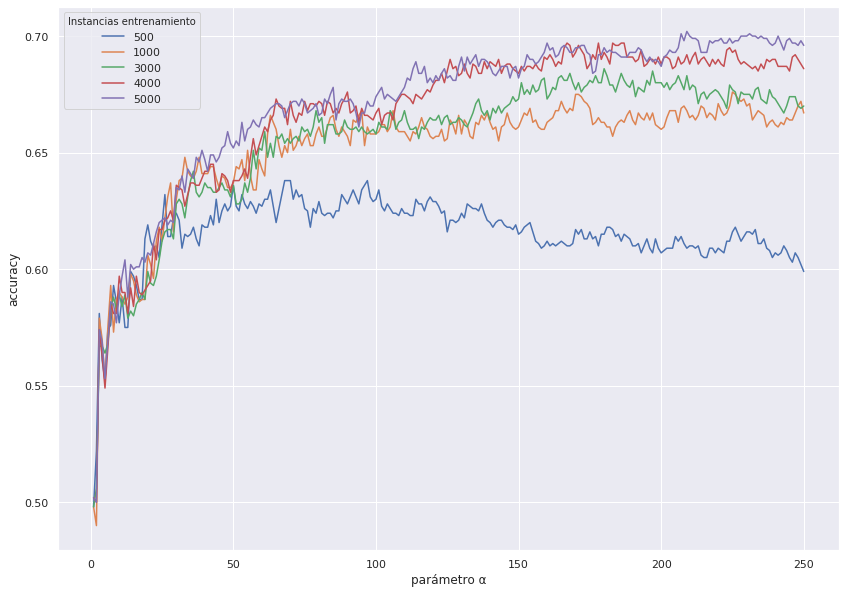

In [29]:
plt.figure(figsize=(14, 10))
ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==500)], label='500')
ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==1000)], label='1000')
#ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==2000)], label='2000')
ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==3000)], label='3000')
ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==4000)], label='4000')
ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==5000)], label='5000')
#ax = sns.lineplot(x="component", y="acc", data=df[(df['size']==6000)], label='6000')
ax.set(xlabel='parámetro α', ylabel='accuracy')
ax.legend().set_title('Instancias entrenamiento')